<a href="https://colab.research.google.com/github/abosalah0/Codveda-Technology/blob/main/Advanced_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Core
import pandas as pd
import numpy as np

# Modeling & preprocessing
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Metrics & plots
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42

def find_target_column(columns):
    # Find the column that looks like "churn", case-insensitive
    for c in columns:
        if "churn" in c.lower():
            return c
    raise ValueError("Could not auto-detect a 'churn' column. Please check the CSV headers.")

def to_binary_series(y):
    """
    Convert common churn labels to binary {0,1}.
    Accepts True/False, Yes/No, 'True.' style, 'yes','no', '1','0'.
    """
    return (
        pd.Series(y)
        .astype(str)
        .str.strip()
        .str.lower()
        .map({
            'yes': 1, 'true': 1, 'true.': 1, '1': 1, 'y': 1, 't': 1,
            'no': 0, 'false': 0, 'false.': 0, '0': 0, 'n': 0, 'f': 0
        })
        .fillna(pd.Series(y).astype(int, errors='ignore')) # fallback if already 0/1
        .astype(int)
    )


In [3]:
# Adjust the paths if your filenames differ in your Colab
train_path = "churn-bigml-80.csv"  # training (80%)
test_path  = "churn-bigml-20.csv"  # holdout test (20%)

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

# Auto-detect target column
target_col = find_target_column(train_df.columns)
print("Detected target column:", target_col)

# Separate features/target
X_train_raw = train_df.drop(columns=[target_col])
y_train_raw = to_binary_series(train_df[target_col])

X_test_raw  = test_df.drop(columns=[target_col])
y_test_raw  = to_binary_series(test_df[target_col])

print("Positive rate (train):", y_train_raw.mean().round(3))
print("Positive rate (test) :", y_test_raw.mean().round(3))


Train shape: (2666, 20)
Test shape : (667, 20)
Detected target column: Churn
Positive rate (train): 0.146
Positive rate (test) : 0.142


In [4]:
# Identify dtypes
cat_cols = X_train_raw.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train_raw.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns    :", num_cols)

# Column transformer
# NOTE: OneHotEncoder param compatibility across sklearn versions handled by try/except.
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", StandardScaler(), num_cols)
    ],
    remainder="drop"
)


Categorical columns: ['State', 'International plan', 'Voice mail plan']
Numeric columns    : ['Account length', 'Area code', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']


In [5]:
# Pipelines
svm_linear = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SVC(kernel="linear", probability=True, random_state=RANDOM_STATE))
])

svm_rbf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=RANDOM_STATE))
])

# Cross-validate on train set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def cv_report(model, X, y, name):
    acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    prc = cross_val_score(model, X, y, cv=cv, scoring="precision")
    rcl = cross_val_score(model, X, y, cv=cv, scoring="recall")
    auc = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    print(f"\n{name} — 5-fold CV:")
    print(f"Accuracy: {acc.mean():.3f} ± {acc.std():.3f}")
    print(f"Precision: {prc.mean():.3f} ± {prc.std():.3f}")
    print(f"Recall: {rcl.mean():.3f} ± {rcl.std():.3f}")
    print(f"AUC: {auc.mean():.3f} ± {auc.std():.3f}")

cv_report(svm_linear, X_train_raw, y_train_raw, "SVM (Linear kernel)")
cv_report(svm_rbf,    X_train_raw, y_train_raw, "SVM (RBF kernel)")


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p


SVM (Linear kernel) — 5-fold CV:
Accuracy: 0.855 ± 0.001
Precision: 0.150 ± 0.300
Recall: 0.008 ± 0.015
AUC: 0.781 ± 0.009

SVM (RBF kernel) — 5-fold CV:
Accuracy: 0.904 ± 0.007
Precision: 0.856 ± 0.061
Recall: 0.415 ± 0.034
AUC: 0.894 ± 0.012


In [6]:
# Fit both on full training data
svm_linear.fit(X_train_raw, y_train_raw)
svm_rbf.fit(X_train_raw, y_train_raw)

# Predict on test
for name, model in [("Linear", svm_linear), ("RBF", svm_rbf)]:
    y_prob = model.predict_proba(X_test_raw)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_test_raw, y_pred)
    prc = precision_score(y_test_raw, y_pred)
    rcl = recall_score(y_test_raw, y_pred)
    auc = roc_auc_score(y_test_raw, y_prob)

    print(f"\n=== Test Performance: SVM ({name}) ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prc:.3f}")
    print(f"Recall   : {rcl:.3f}")
    print(f"AUC      : {auc:.3f}")
    print("\nClassification report:")
    print(classification_report(y_test_raw, y_pred, digits=3))

    print("Confusion matrix:")
    print(confusion_matrix(y_test_raw, y_pred))



=== Test Performance: SVM (Linear) ===
Accuracy : 0.858
Precision: 0.000
Recall   : 0.000
AUC      : 0.769

Classification report:
              precision    recall  f1-score   support

           0      0.858     1.000     0.923       572
           1      0.000     0.000     0.000        95

    accuracy                          0.858       667
   macro avg      0.429     0.500     0.462       667
weighted avg      0.735     0.858     0.792       667

Confusion matrix:
[[572   0]
 [ 95   0]]

=== Test Performance: SVM (RBF) ===
Accuracy : 0.925
Precision: 0.817
Recall   : 0.611
AUC      : 0.930

Classification report:
              precision    recall  f1-score   support

           0      0.938     0.977     0.957       572
           1      0.817     0.611     0.699        95

    accuracy                          0.925       667
   macro avg      0.877     0.794     0.828       667
weighted avg      0.921     0.925     0.920       667

Confusion matrix:
[[559  13]
 [ 37  58]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best kernel by AUC on test: RBF (AUC=0.930)


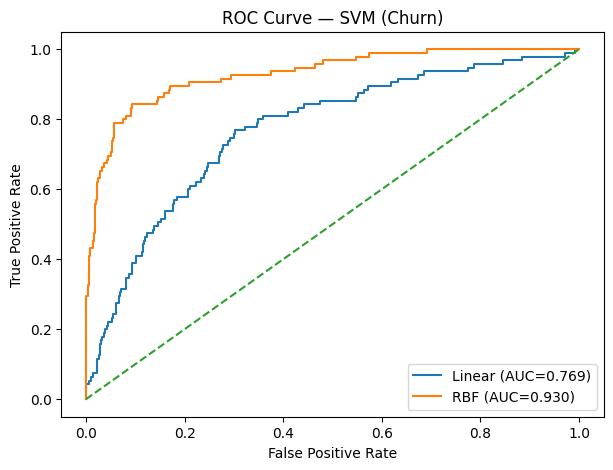

In [7]:
# Choose the better model by AUC on test
def test_metrics(model):
    y_prob = model.predict_proba(X_test_raw)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    return {
        "y_prob": y_prob, "y_pred": y_pred,
        "acc": accuracy_score(y_test_raw, y_pred),
        "prc": precision_score(y_test_raw, y_pred),
        "rcl": recall_score(y_test_raw, y_pred),
        "auc": roc_auc_score(y_test_raw, y_prob)
    }

m_lin = test_metrics(svm_linear)
m_rbf = test_metrics(svm_rbf)

best_name = "RBF" if m_rbf["auc"] >= m_lin["auc"] else "Linear"
best_model = svm_rbf if best_name == "RBF" else svm_linear
best = m_rbf if best_name == "RBF" else m_lin

print(f"\nBest kernel by AUC on test: {best_name} (AUC={best['auc']:.3f})")

# Plot ROC curve for both
plt.figure(figsize=(7,5))
for name, m in [("Linear", m_lin), ("RBF", m_rbf)]:
    fpr, tpr, _ = roc_curve(y_test_raw, m["y_prob"])
    plt.plot(fpr, tpr, label=f"{name} (AUC={m['auc']:.3f})")

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — SVM (Churn)")
plt.legend()
plt.show()


Goal: Train an SVM model for churn prediction, compare Linear vs RBF kernels, and evaluate with Accuracy, Precision, Recall, AUC, and ROC curves.

✅ Steps Performed

Loaded training set (churn-bigml-80.csv) and test set (churn-bigml-20.csv).

Identified target column Churn and converted labels to binary (1 = churn, 0 = no churn).

Preprocessed data:

One-Hot Encoding for categorical (State, International plan, Voice mail plan).

Standard Scaling for numerical features (call minutes, charges, service calls, etc.).

Built two pipelines:

SVM with linear kernel

SVM with RBF kernel

Evaluated both with 5-fold CV on the training set and final evaluation on the test set.

Plotted ROC curve comparing linear vs RBF.

📊 Results

Cross-validation (training set):

Linear SVM: Accuracy ≈ 0.855, Precision ≈ 0.150, Recall ≈ 0.008, AUC ≈ 0.781

RBF SVM: Accuracy ≈ 0.904, Precision ≈ 0.856, Recall ≈ 0.415, AUC ≈ 0.894

Test set:

Linear SVM:

Accuracy = 0.858

Precision = 0.000

Recall = 0.000

AUC = 0.769

Confusion matrix: predicted all customers as non-churn (failed to capture positives).

RBF SVM:

Accuracy = 0.925

Precision = 0.817

Recall = 0.611

AUC = 0.930

Confusion matrix: correctly identified 58 churners, with some false negatives (37).

🔎 Key Insights

Linear SVM failed → it predicted no churn cases at all (zero recall).

RBF SVM performed strongly → excellent balance between accuracy (92.5%), precision (81.7%), and recall (61.1%).

AUC (0.930) shows the RBF model discriminates well between churn and non-churn customers.

The ROC curve confirmed RBF’s superiority over linear.

✅ Conclusion

An SVM with RBF kernel is highly effective for churn prediction on this dataset, while a linear kernel is inadequate. The RBF model provides both high overall accuracy and meaningful churn detection, making it suitable for business applications.